In [1]:
import pandas as pd
import numpy as np

# raw_data 불러오기
raw_data = pd.read_csv("data/train.csv")
raw_data.dropna(inplace=True)
raw_data.reset_index(drop=True,inplace=True)

# X, y 나누기
y = raw_data["Transported"].map({True: "True", False: "False"})
X = raw_data.drop(columns="Transported")


# cabin column 세분화
cabin = X["Cabin"].str.split("/", expand=True)
cabin.columns = ["deck", "deck_num", "deck_side"]


# PassengerId column 세분화
pid = X["PassengerId"].str.split("_", expand=True)
pid.columns = ["group", "group_number"]
pid["group_number"] = pid["group_number"].apply(lambda x: x[1])

# cabin & passengerId 업데이트
X_new = pd.concat([X.drop(columns=["Cabin", "PassengerId"]), cabin, pid], axis=1)


for c_name in X.select_dtypes("float").columns.drop(labels=["Age"]):

    # numerical data를 log scale로 
    X_new[c_name][X_new[c_name] > 0] = np.log(X_new[c_name][X_new[c_name] > 0])
    X_new[c_name] = X_new[c_name].map(lambda x : round(x,2))
    # numerical data를 이용 여부로 나누기
    X_new[f"{c_name}_cat"] = pd.cut(
        X_new[c_name], bins=[-1, 0.5, 999999], labels=['False', 'True']
    ).astype("object")


/var/folders/rh/7xnmdybn7778kzq927hfcn8c0000gn/T/ipykernel_39605/2203301210.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new[c_name][X_new[c_name] > 0] = np.log(X_new[c_name][X_new[c_name] > 0])
/var/folders/rh/7xnmdybn7778kzq927hfcn8c0000gn/T/ipykernel_39605/2203301210.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new[c_name][X_new[c_name] > 0] = np.log(X_new[c_name][X_new[c_name] > 0])
/var/folders/rh/7xnmdybn7778kzq927hfcn8c0000gn/T/ipykernel_39605/2203301210.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

### object type EDA


In [2]:
# plot용 데이터셋 생성
obj_data = X_new.select_dtypes("object").drop(columns=["Name", "deck_num", "group"])

obj_data.head()


,HomePlanet,CryoSleep,Destination,VIP,deck,deck_side,group_number,RoomService_cat,FoodCourt_cat,ShoppingMall_cat,Spa_cat,VRDeck_cat
0,Europa,False,TRAPPIST-1e,False,B,P,1,False,False,False,False,False
1,Earth,False,TRAPPIST-1e,False,F,S,1,True,True,True,True,True
2,Europa,False,TRAPPIST-1e,True,A,S,1,True,True,False,True,True
3,Europa,False,TRAPPIST-1e,False,A,S,2,False,True,True,True,True
4,Earth,False,TRAPPIST-1e,False,F,S,1,True,True,True,True,True


In [3]:
for c in obj_data.columns:
    print(f"{c} : " ,obj_data[c].unique(), "| num of unique : ", len(obj_data[c].unique()))

print('\ncolumn 개수 : ',len(obj_data.columns))


HomePlanet :  ['Europa' 'Earth' 'Mars'] | num of unique :  3
CryoSleep :  [False True] | num of unique :  2
Destination :  ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e'] | num of unique :  3
VIP :  [False True] | num of unique :  2
deck :  ['B' 'F' 'A' 'G' 'E' 'C' 'D' 'T'] | num of unique :  8
deck_side :  ['P' 'S'] | num of unique :  2
group_number :  ['1' '2' '3' '4' '6' '5' '7' '8'] | num of unique :  8
RoomService_cat :  ['False' 'True'] | num of unique :  2
FoodCourt_cat :  ['False' 'True'] | num of unique :  2
ShoppingMall_cat :  ['False' 'True'] | num of unique :  2
Spa_cat :  ['False' 'True'] | num of unique :  2
VRDeck_cat :  ['False' 'True'] | num of unique :  2

column 개수 :  12


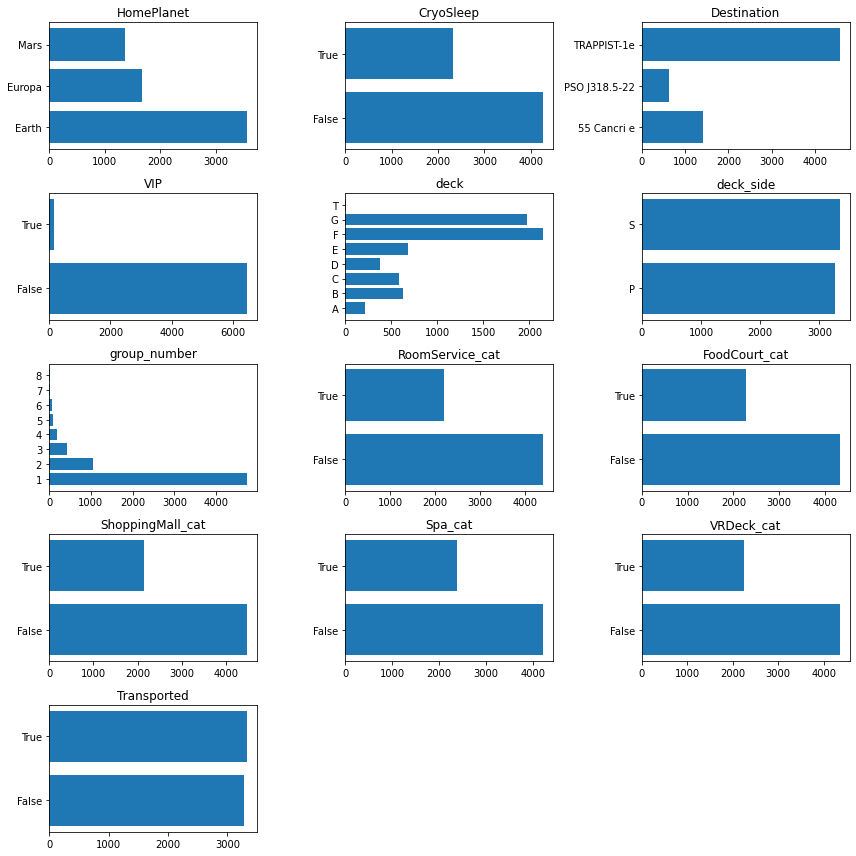

In [4]:
import matplotlib.pyplot as plt

obj_data["Transported"] = y

# feature 시각화
plt.figure(figsize=(12, 12))
for n, c in enumerate(obj_data.columns):
    plt.subplot(5, 3, n + 1)
    val_cnt = obj_data[c].value_counts().sort_index()
    plt.barh(list(map(str, val_cnt.index)), val_cnt)
    plt.title(c)
plt.tight_layout()
plt.show()


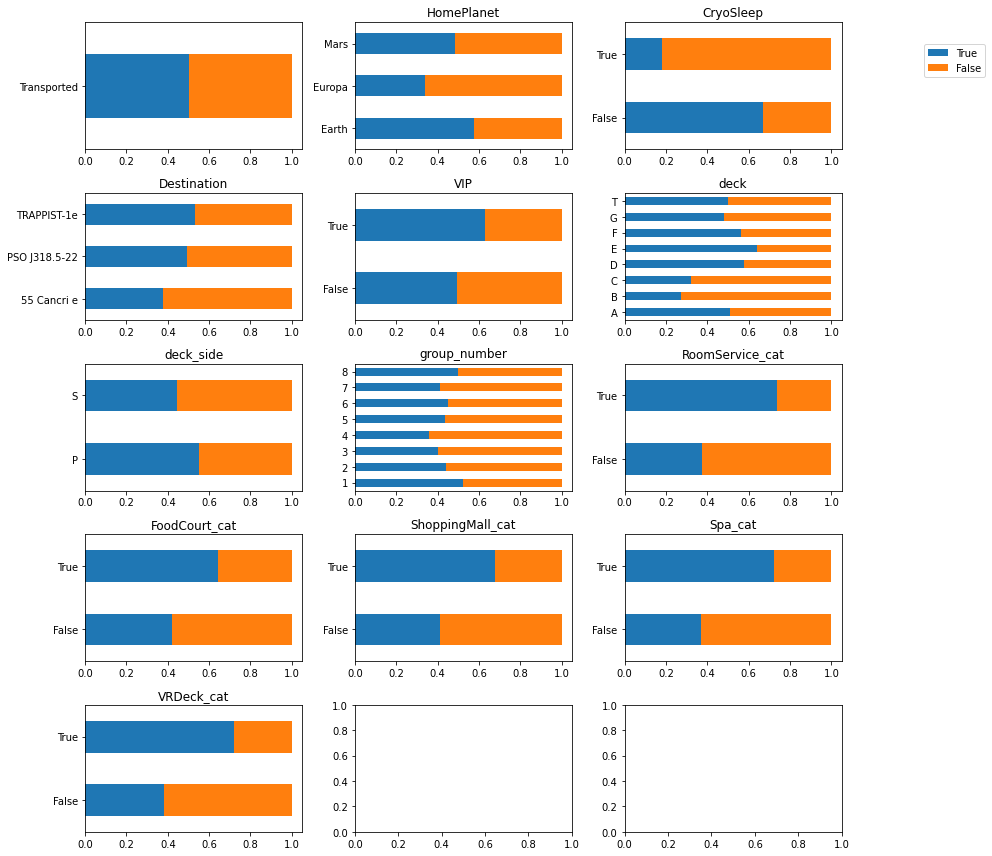

In [5]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 12))


for n, c_name in enumerate(obj_data.columns.drop(labels="Transported")):
    # r : row, c : column
    r, c = divmod(n + 1, 3)

    # 개별 feature와 target feature 비교
    group_df = obj_data.groupby([c_name, "Transported"]).size().unstack()

    # 개별 feature에 대해 target 별 비율 계산 및 시각화
    group_df.div(group_df.sum(axis=1), axis=0).plot(
        kind="barh", ax=axes[r, c], legend=False, stacked=True
    )
    axes[r, c].set_ylabel("")
    axes[r, c].set_title(c_name)


# Transported 비율 확인
target_data = obj_data["Transported"].value_counts()
pd.DataFrame(target_data).T.div(target_data.sum(), axis=0).plot(
    kind="barh", ax=axes[0, 0], stacked=True, legend=False
)


fig.legend(["True", "False"], bbox_to_anchor=(1.15, 0.95))
plt.tight_layout()
plt.show()


### numerical Data EDA


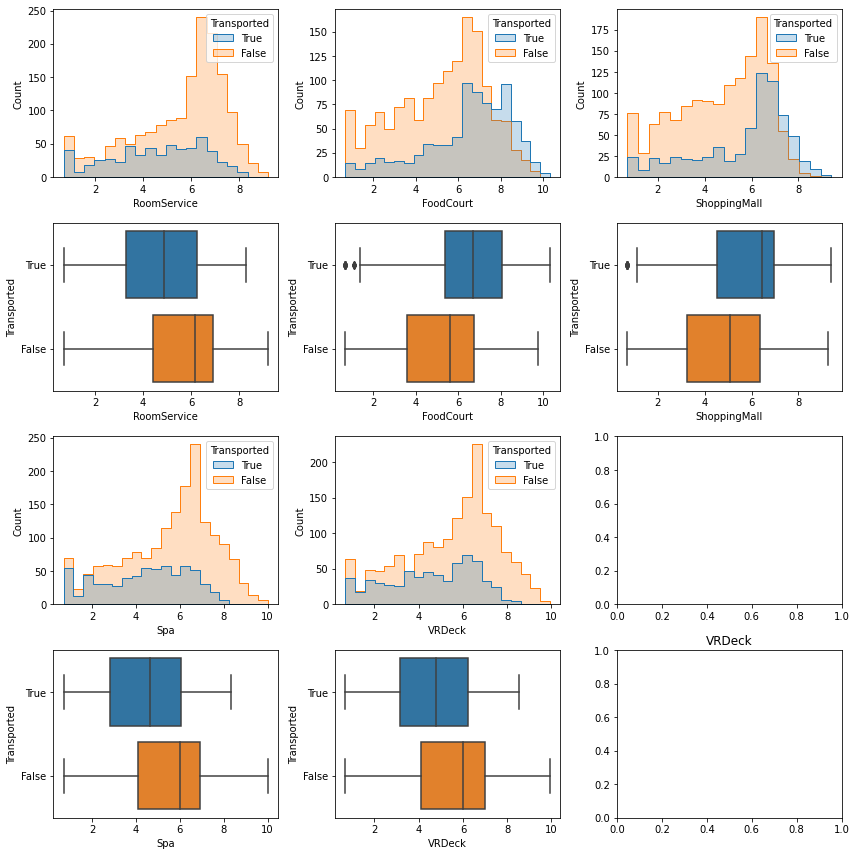

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot용 데이터셋 생성
float_data = X_new.select_dtypes("float")
float_data["Transported"] = y

float_data.head()

# feature 시각화
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
for n, c_name in enumerate(float_data.drop(columns=["Age", "Transported"])):
    r, c = divmod(n, 3)
    new_data = float_data[[c_name, "Transported"]][float_data[c_name] > 0]
    sns.histplot(data=new_data, x=c_name,hue="Transported",ax=axes[r * 2, c],element="step")
    sns.boxplot(data=new_data, x=c_name, y="Transported", ax=axes[(r * 2 + 1), c])
    plt.title(c_name)


plt.tight_layout()
plt.show()


### train & test 파일 분류

In [7]:
from sklearn.model_selection import train_test_split

# split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# save csv files
X_train.to_csv("data/X_train.csv",index=False)
y_train.to_csv("data/y_train.csv",index=False)
X_test.to_csv("data/X_test.csv",index=False)
y_test.to_csv("data/y_test.csv",index=False)